### DERNA/EDANN
### Diseño Evolutivo de Redes Neuronales Artificiales
### Evolutionary Design of Artificial Neural Networks

La red a optimizar está basada en el paper [Predicting Daily Returns of Global Stocks Indices: Neural Networks vs Support Vector Machines. Kaur, Dharni 2019](https://journaljemt.com/index.php/JEMT/article/view/30179)

Este programa intenta mejorar los resultados del paper en ANN para el DJI. Se calcularon los indicadores técnicos según las fórmulas del paper y las indicaciones del autor.

Se usan los datos del DJI desde 20050401 hasta 20170331.
En el artículo, el autor logra una pérdida de 0.001-0.013 (media de 0.004), mi reproducción logra 0.0027, este programa luego de optimizar el número de neuronas y el tamaño del lote logra 0.0015 que es 44% mejor.

optimize_kaur

V 1.0 20210613 Primera versión optimizando neuronas y batch_size, basado en baseline_kaur V 4.0. Se agrega el código del AG. Se cambia la lectura del csv de Pandas a Numpy.

The network to be optimized is based on the paper [Predicting Daily Returns of Global Stocks Indices: Neural Networks vs Support Vector Machines. Kaur, Dharni 2019](https://journaljemt.com/index.php/JEMT/article/view/30179)

This programs tries to optimize the paper results on ANN for DJI. The technical indicators were calculated based on the paper formulas and the author advise.

This program uses DJI data from 20050401 until 20170331.
In the paper the author achieves a loss of 0.001-0.013 (mean of 0.004), my reproduction achieves 0.0027, after the optimization of number of neurons and batch size it achieves 0.0015 which is 44% better.

optimize_kaur

V 1.0 20210613 First version optimizing neurons and batch_size, based on baseline_kaur V 4.0. Adds GA code. Change csv read from Pandas to Numpy.


### Configuración
### Setup

#### Importar librerías y funciones
#### Import libraries and functions

In [ ]:
!pip install -U tensorflow-addons
import numpy as np
import sklearn.preprocessing as skp
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

Requirement already up-to-date: tensorflow-addons in /usr/local/lib/python3.7/dist-packages (0.13.0)


In [ ]:
!pip install -U deap
import random
import datetime
import sklearn.metrics as skm
from deap import base, creator, tools, algorithms

Requirement already up-to-date: deap in /usr/local/lib/python3.7/dist-packages (1.3.1)


#### Hiperparámetros
#### Hyperparameters

In [ ]:
p = {
     # RNA/ANN
     "neurons": 9,  # neuronas escondidas/hidden layer neurons
     "activation": "sigmoid",  # para la capa oculta/for the hidden layer
     "output_activation": "linear",  # capa de salida/output layer

     # entrenamiento/training
     "scaler": skp.MinMaxScaler(feature_range=(-1,1)),
     "loss": "mse",  # podría ser mae o mse/could be mae or mse
     "optimizer": tf.keras.optimizers.SGD(
         learning_rate=0.3,
         momentum=0.2,
         nesterov=False),
     "test_split": 0.20,  # 20% para prueba/20% of samples for test data
     "val_split": 0.0,  # sin validación/no validation
     "seconds": 5,  # límite de tiempo para entrenar/training time limit
     "epochs": 500,  # épocas de entrenamiento/training epochs
     "batch_size": 100,
     "shuffle": False,  # los datos de entrenamiento/the training data
     "verbose": 0,  # verbosidad del entrenamiento/verbose training

     # AG/GA
     "population" : 20,  # número de individuos en la población
     # debe escogerse basado en el tamaño del espacio a optimizar
     # entre más alto mejor cerca de sqrt(tamaño del espacio)
     # number of individuals in population
     # should be chosen based on the size of the optimization space
     # (better high around sqrt(space size))
     "ngen" : 5,  # número de generaciones (suficiente para que converga)
     # DERNA no hace evaluaciones redundantes, por lo que no es peligroso
     # un número alto
     # number of generations (just high enough)
     # EDANN does no redundant evaluations so a high value is not a problem
     "alpha" : 0.2,  # sobrepeso del alpha blend (no debe ser muy alto)
     # alpha blend oversize (better not too high)
     "sigma": 0.1,  # para la mutación gausiana
     # for gaussian mutation
     "indpb": 0.2,  # para la mutación gausiana
     # for gaussian mutation
     "tournsize" : 3,  # tamaño del torneo
     # tournament size
     "cxpb" : 0.6,  # probabilidad de cruce (mejor alta)
     # crossover probability (better high)
     "mutpb" : 0.01,  # probabilidad de mutación (mejor baja)
     # mutation probability (better low)

     # optimizador/optimizer
     "ngenes" : 2,  # número de genes en el cromosoma
     # number of genes in a chromosome
     "genes" : ("neurons", "batch_size"),
     "min" : (5, 10),  # mínimo valor de cada gen
     # minimun value of each gene
     "range" : (8, 200),  # rango de valores de cada gen
     # range of values of each gene
     "type" : ("I", "I"),  # tipo de cada gen, I entero, Real, Ordinal
     # type of gene Integer, Real, Ordinal
     "ordinals" : ([], []),
     # lista de valores para los genes ordinales
     # list of values for ordinal genes
    }

#### Carga de datos
#### Data load

In [ ]:
# copiar el archivo del repositorio
# copy file from repository
path_to_downloaded_file = tf.keras.utils.get_file(
    "baseline_kaur.csv",
    "https://raw.githubusercontent.com/" +
    "jmacostap/webstore/master/baseline_kaur.csv",
    cache_dir="/content",
    )
data = np.loadtxt(path_to_downloaded_file, skiprows=1, delimiter=",")
print(f"{data.shape} samples read")

# extraer objetivos/extract targets
targets = np.reshape(data[:, -1], (-1, 1))
print(f"Targets to be used: {targets.shape}")

# extraer datos/extract features
data = data[:, :-1]
print(f"Samples to be used: {data.shape}")

# reservar datos de prueba/reserve test data
test_index = np.int(len(data)*p["test_split"])
test_split = len(data) - test_index
print(f"Test fraction: {test_index}")
train_targets = targets[:-test_index]
print(f"Train targets: {train_targets.shape}")
train_data = data[:-test_index]
print(f"Train samples: {train_data.shape}")
test_targets = targets[-test_index:]
print(f"Test targets: {test_targets.shape}")
test_data = data[-test_index:]
print(f"Test samples: {test_data.shape}")

# normalizar datos/normalize data
data_scaler = p["scaler"]  # should fit only the train set
train_data = data_scaler.fit_transform(train_data)
test_data = data_scaler.transform(test_data)
targets_scaler = p["scaler"]  # they should be different instances
train_targets = targets_scaler.fit_transform(train_targets)
test_targets = targets_scaler.transform(test_targets)

(3022, 13) samples read
Targets to be used: (3022, 1)
Samples to be used: (3022, 12)
Test fraction: 604
Train targets: (2418, 1)
Train samples: (2418, 12)
Test targets: (604, 1)
Test samples: (604, 12)


#### Creación de la RNA
#### ANN Creation

In [ ]:


def create_ann(p, train_data, train_targets):
    """Crea una RNA con los parámetros de p y la entrena con train_data
    Create an ANN with the parameters on p and train it with train_data

    Args:
    p: dict: of hyperparameters
    train_data: flat array-like: of training data
    train_targets: flat array-like: of training targets
    
    Returns:
    ann: keras.model: the trained neural network
    history: keras.history: the training history
    """

    # asegura reproducibilidad y consistencia
    # ensure reproducibility and consistency
    tf.random.set_seed(31416)  # keras

    # definir el modelo/define the model
    ann = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(
                p["neurons"],
                activation=p["activation"],
            ),
            tf.keras.layers.Dense(
                units=1,
                activation=p["output_activation"],
            ),
        ]
    )

    # crear el modelo/create the model
    ann.compile(
        optimizer=p["optimizer"],
        loss=p["loss"],
    )

    time_stopping_callback = tfa.callbacks.TimeStopping(
        seconds=p["seconds"], verbose=1)

    # Entrenar el modelo/train the model
    history = ann.fit(
        train_data,
        train_targets,
        epochs=p["epochs"],
        batch_size=p["batch_size"],
        verbose=p["verbose"],
        callbacks=[time_stopping_callback],
        validation_split=p["val_split"],
        shuffle=p["shuffle"],
        #use_multiprocessing=True,
    )
    return ann, history



#### Crear y evaluar la RNA descrita por un cromosoma
#### Create and evaluate the ANN described by a chromosome

In [ ]:

def extract_fenotype(chromosome, p):
    """Construye el fenotipo correspondiente a un genotipo/cromosoma
    Build the corresponding fenotype for a genotype/chromosome

    Args:
    chromosome: list: of genes. Each gene is a float that describes an
                ANN feature
    p: dict: of hyperparameters

    Returns:
    fenotype: tuple: of hyperparámeters
    """

    fenotype_list=[]
    for i in range(p["ngenes"]):
        j = chromosome[i] * p["range"][i] + p["min"][i]
        if p["type"][i] == "I":
            fenotype_list.append(int(j))
        elif p["type"][i] == "R":
            fenotype_list.append(j)
        else:
            fenotype_list.append(p["ordinals"][i][int(j)])

    return tuple(fenotype_list)


def set_fenotype(fenotype, p):
    """Fija los hiperparámetros en p según un fenotipo
    Set hyperparameters in p as per a fenotype

    Args:
    fenotype: tuple: of parameter values
    p: dict: of hiperparámeters

    Returns:
    p values set as per fenotype
    """

    for i in range(p["ngenes"]):
        p[p["genes"][i]] = fenotype[i]


def print_fenotype(fenotype, p):
    """Muestra los valores de un fenotipo
    Pretty-print the values of a fenotype

    Args:
    fenotype: tuple: of hiperparámeters
    p: dict: of hiperparámeters

    Returns:
    Nothing
    """

    for i, j in zip(p["genes"], fenotype):
        print(i, j, "", end="")
    print("")


def evaluate_chromosome(chromosome, p, train_data,
                        train_targets, seen_fenotypes):
    """Construir, entrenar y evaluar la RNA descrita por un cromosoma
    - Extraer el fenotipo del cromosoma
    - Si ya ha sido evaluado, devolver la pérdida inmediatamente
    - si no, crear la RNA, entrenarla y evaluarla
    - finalmente guardar los errores de entrenamiento y validación

    Build, train and evaluate the ANN represented by a chromosome
    - Extract the fenotype from the chromosome
    - If it has been previously evaluated return the loss immediately
    - otherwise create train and evaluate the ann
    - finally save the training and validation loss

    Args:
    chromosome: list: of genes. Each gene is a float that describes an
                ANN feature
    p: dict: of hyperparameters
    train_data: flat array-like: data for training
    train_targets: flat array-like: targets for training
    seen_fenotypes: dict: evaluated fenotypes and their losses

    Returns:
    (float,): Validation loss
    """

    fenotype = extract_fenotype(chromosome, p)
    set_fenotype(fenotype, p)
    print_fenotype(fenotype, p)

    # evita evaluar de nuevo el mismo fenotipo
    # avoid evaluating the same fenotype twice
    if fenotype in seen_fenotypes:
        return seen_fenotypes[fenotype][0],  # loss=0 val_loss=1

    # construye la RNA
    # build the ANN
    model, history = create_ann(p, train_data, train_targets)

    # extrae y despliega los errores
    # extract and display training and validation loss
    if p["val_split"] > 0.0:
        val_loss = history.history["val_loss"][-1]
        loss = history.history["loss"][-1]
        print("Training error: {} Validation error: {}".format(loss, val_loss))
    else:
        loss = history.history["loss"][-1]
        print("Training error: {}".format(loss))

    # finalmente guarda los errores
    # finally, save the losses
    if p["val_split"] > 0.0:
        seen_fenotypes[fenotype] = val_loss, loss
        return val_loss,
    else:
        seen_fenotypes[fenotype] = loss,
        return loss,



#### Crea la definición de ajuste
#### Create the fitness definition

In [ ]:
# normalmente fitness trata de maximizar, se usa peso negativo para maximizar
# fitness normally tries to maximize we use negative weight to minimize
#creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


#### Definir el resto de los operadores genéticos en el toolbox
#### Define the rest of the genetic operators on the toolbox

In [ ]:
toolbox = base.Toolbox()
toolbox.register("attr_float", random.random)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_float, n=p["ngenes"])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def checkBounds(min, max):
    """Decorador para ajustar el valor del gen si se sale de rango
    Decorator to adjust the gene value in case it is out of bounds

    Args:
    min: minimum value
    max: maximum value

    Returns:
    The function that checks bounds to decorate mate or mutate on the toolbox
    """

    def decorator(func):
        def wrapper(*args, **kargs):
            offspring = func(*args, **kargs)
            for child in offspring:
                for i in range(len(child)):
                    if child[i] > max:
                        child[i] = max
                    elif child[i] < min:
                        child[i] = min
            return offspring
        return wrapper
    return decorator


# mate by Alpha Blend
toolbox.register("mate", tools.cxBlend, alpha=p["alpha"])
# stay within [0,1)
toolbox.decorate("mate", checkBounds(0.0, 0.99999999999999))
# mutate by gaussian perturbation
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=p["sigma"],
                 indpb=p["indpb"])
# stay within [0,1)
toolbox.decorate("mutate", checkBounds(0.0, 0.99999999999999))
toolbox.register("select", tools.selTournament, tournsize=p["tournsize"])
# initialize seen list to avoid multiple evaluations
seen_fenotypes = {}
toolbox.register("evaluate", evaluate_chromosome, p=p, train_data=train_data,
                 train_targets=train_targets, seen_fenotypes=seen_fenotypes)



### El Algoritmo Genético
### The Genetic Algorithm

#### Ejecuta el AG
#### Run the GA

In [ ]:
# siembra el generador aleatorio para asegurar reproducibilidad
# seed the random generator to ensure reproducibility
random.seed(31416) # DEAP/EDANN

seen_fenotypes = {}

population = toolbox.population(n=p["population"])
log = algorithms.eaSimple(population, toolbox, cxpb=p["cxpb"],
                           mutpb=p["mutpb"], ngen=p["ngen"], verbose=True)



neurons 9 batch_size 204 
Timed stopping at epoch 495 after training for 0:00:05
Training error: 0.0031486761290580034
neurons 10 batch_size 182 
Timed stopping at epoch 436 after training for 0:00:05
Training error: 0.0032252829987555742
neurons 8 batch_size 153 
Timed stopping at epoch 393 after training for 0:00:05
Training error: 0.0032465695403516293
neurons 9 batch_size 148 
Timed stopping at epoch 362 after training for 0:00:05
Training error: 0.0032571773044764996
neurons 5 batch_size 101 
Timed stopping at epoch 271 after training for 0:00:05
Training error: 0.0032892723102122545
neurons 11 batch_size 142 
Timed stopping at epoch 351 after training for 0:00:05
Training error: 0.0032398344483226538
neurons 6 batch_size 126 
Timed stopping at epoch 321 after training for 0:00:05
Training error: 0.0032669466454535723
neurons 7 batch_size 200 
Timed stopping at epoch 468 after training for 0:00:05
Training error: 0.003300122916698456
neurons 9 batch_size 48 
Timed stopping at epoc

#### Muestra las mejores soluciones
#### Show the best solutions

In [ ]:
best_individuals = tools.selBest(population, k=len(population))
# extraer los mejores fenotipos
# extract best fenotype
best_fenotype = extract_fenotype(best_individuals[0], p)
for chromosome in best_individuals:
    fenotype = extract_fenotype(chromosome, p)
    print_fenotype(fenotype, p)


neurons 12 batch_size 16 
neurons 12 batch_size 16 
neurons 12 batch_size 16 
neurons 12 batch_size 16 
neurons 12 batch_size 16 
neurons 12 batch_size 16 
neurons 12 batch_size 16 
neurons 12 batch_size 17 
neurons 12 batch_size 17 
neurons 12 batch_size 17 
neurons 12 batch_size 17 
neurons 12 batch_size 17 
neurons 12 batch_size 17 
neurons 12 batch_size 17 
neurons 12 batch_size 17 
neurons 12 batch_size 17 
neurons 12 batch_size 17 
neurons 12 batch_size 17 
neurons 12 batch_size 17 
neurons 12 batch_size 17 


#### Entrenar y probar al mejor individuo
#### Train the best individual and test it

In [ ]:
# aumentar el tiempo de entrenamiento
# increase training time
p["seconds"] = 199

set_fenotype(best_fenotype, p)
print_fenotype(best_fenotype, p)

# construir la RNA
# build the ANN
ann, history = create_ann(p, train_data, train_targets)

# desplegar los errores de entrenamiento y validación
# display training and validation losses
if (p["val_split"]==0.0):
    print("Training error: {}".
      format(history.history["loss"][-1]))
else:
    print("Training error: {} Validation error: {}".
      format(history.history["loss"][-1], history.history["val_loss"][-1]))

neurons 12 batch_size 16 
Training error: 0.002054978860542178


#### Despliegue gráfico del rendimiento de la RNA entrenada
#### Graphically display the performance of the trained ANN

38/38 [==============================] - 0s 869us/step - loss: 0.0015
ANN train: 0.002468291437253356
ANN test: 0.001512113376520574
MSE of the trained ANN on train data:	0.00246829
MSE of the trained ANN on test data:	0.00151211


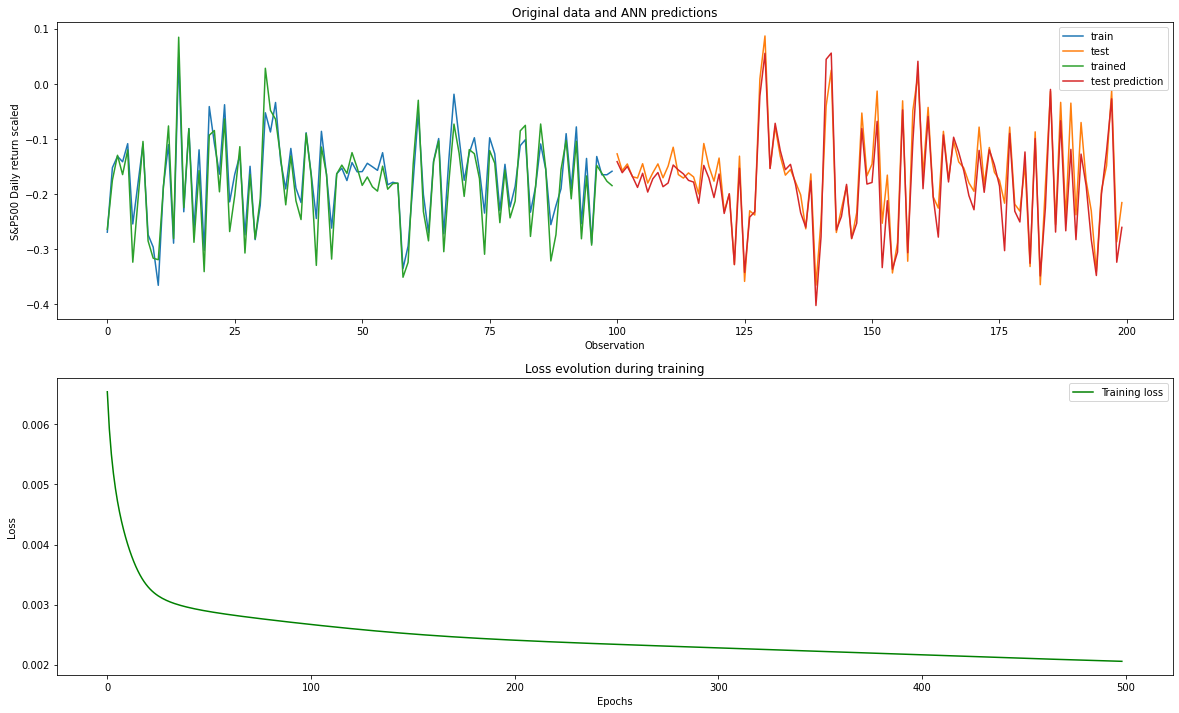

In [ ]:
ann_train_loss = ann.evaluate(x=train_data,
    y=train_targets,
    batch_size=p["batch_size"])
ann_test_loss = ann.evaluate(x=test_data,
    y=test_targets,
    batch_size=p["batch_size"])
y_train_pred = ann.predict(train_data)
y_test_pred = ann.predict(test_data)

print("ANN train: {}".format(ann_train_loss))
print("ANN test: {}".format(ann_test_loss))
print("MSE of the trained ANN on train data:\t{:0.8f}".
        format(skm.mean_squared_error(train_targets, y_train_pred)))
print("MSE of the trained ANN on test data:\t{:0.8f}".
        format(skm.mean_squared_error(test_targets, y_test_pred)))

plt.figure(figsize=(20, 12))
plt.subplot(2,1,1)
#plt.plot(range(test_split), train_targets, label="train")
plt.plot(range(0, 100), train_targets[0:100], label="train")
#plt.plot(range(test_split, len(data)), test_targets, label="test")
plt.plot(range(100, 200), test_targets[0:100], label="test")
#plt.plot(range(test_split), y_train_pred, label="trained")
plt.plot(range(0, 100), y_train_pred[0:100], label="trained")
#plt.plot(range(test_split, len(data)), y_test_pred, label="test prediction")
plt.plot(range(100, 200), y_test_pred[0:100], label="test prediction")
plt.title("Original data and ANN predictions")
plt.xlabel("Observation")
plt.ylabel("S&P500 Daily return scaled")
plt.legend()

skip = 1  # si los primeros valores son muy altos se pueden eliminar
# del gráfico para evitar que afecten la escala automática
# avoid autoscale issues
plt.subplot(2,1,2)
plt.plot(history.history["loss"][skip:], "g",
            label="Training loss")
if (p["val_split"] != 0.0):
    plt.plot(history.history["val_loss"][skip:], "b",
                label="Validation loss")
plt.title("Loss evolution during training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
